In [1]:
import numpy as np
import pandas as pd
from ase import Atoms
from ase import neighborlist
from ase import units
from ase.io import read, write
from ase.io.trajectory import Trajectory
from ase.md.verlet import VelocityVerlet
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.io.extxyz import read_extxyz, write_extxyz
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
pred_step = 4
input = 8
file = r"Data\EtOH_moldyn_for.xyz"

#The function takes arrays of forces and returns a VAR OLS model
#_____Inputs______
# main - 1D np array with the time series which the model fits to.
# secondary - 2D np array with the secondary time series used to predict the main time series
# order - Positive integer which decides the numper of points in the past is used to predict the next point
#
#_____Output______
# Returns a OLS model that uses the main and secondary time series to predict the main time series. In order to predict t+2 of the main timeseries,
# t+1 of both main and secondary time series must be known. If the values of the secondary time series is not known this can be done by also creating models
# for the secondary time series and use those to predict the value at t+1
def create_VAR_OLS_model(main, secondary, order=2):
    input = len(main)-order
    num_secondaries = secondary.shape[0]
    X = np.zeros([input,order*(num_secondaries+1)+1])
    for i in range(order):
        X[:,i*(num_secondaries+1)] = main[i:input+i]
        for j in range(num_secondaries):
            X[:,i*(num_secondaries+1)+j+1] = secondary[j,i:input+i]
    X[:,-1] = np.ones(len(main)-order)
    return sm.OLS(main[order:], X)

# Returns 3 fitted models from create_VAR_OLS_model to create 3 models to respectively predict the forces in x, y, and z direction for an atom in a molecule.
# Uses L2 regularized fitting.
#_____Inputs______
# forces - 2D np array with the three force time series for the atom chosen. Has the shape [N, 3] where N is the number of input points in the model.
# order - Positive integer which decides the numper of points in the past is used to predict the next point
#
#_____Output______
# Returns 3 fitted VAR OLS which can be used to predict future points in the time series. t+1 must be predicted for all three time series before t+2 can be predicted.
def create_atom_OLS_model(forces, order=2):
    model_x = create_VAR_OLS_model(forces[0,:], np.array([forces[1,:],forces[2,:]]), order=order).fit_regularized(method="elastic_net", L1_wt=0)
    model_y = create_VAR_OLS_model(forces[1,:], np.array([forces[0,:],forces[2,:]]), order=order).fit_regularized(method="elastic_net", L1_wt=0)
    model_z = create_VAR_OLS_model(forces[2,:], np.array([forces[0,:],forces[1,:]]), order=order).fit_regularized(method="elastic_net", L1_wt=0)
    return model_x, model_y, model_z

# Function which predicts the forces on the atoms in a molecule for a certain number of time steps
#_____Inputs______
# file - String with the name of the xyz file containing information on the molecule
# input - Positive integer with the number of data points used as input in training the OLS VAR models
# pred_step - Positive integer which decides the number of time steps predicted by the OLS VAR models
# order - Positive integer which decides the numper of points in the past is used to predict the next point
#
#_____Output______
# Returns a 3D np array with the predicted forces. The array as the following shape [N, 3, p], with N being the number of atoms in the molecule
# and p being the number of time steps predicted
def predict_forces(file=file, input=input, pred_step=pred_step, order=2):
    #mol = read(file, index=slice(-input, None))
    mol = read(file, index=':8')
    n_atoms = mol[0].get_global_number_of_atoms()
    predicted_forces = np.zeros((n_atoms, 3, pred_step))
    forces = np.zeros((n_atoms, 3, input))

    for i in range(len(mol)):
        forces[:,:,i] = mol[i].get_forces()
    for i in range(n_atoms):
    
        model_x, model_y, model_z = create_atom_OLS_model(forces[i,:,:], order=order)
        forecast_forces = np.zeros((3, pred_step+order))
        forecast_forces[:,:order] = forces[i,:,-order:]
        for j in range(pred_step):
            input_x = np.array([forecast_forces[0,j], forecast_forces[1,j], forecast_forces[2,j], forecast_forces[0,j+1], forecast_forces[1,j+1], forecast_forces[2,j+1], 1])
            input_y = np.array([forecast_forces[1,j], forecast_forces[0,j], forecast_forces[2,j], forecast_forces[1,j+1], forecast_forces[0,j+1], forecast_forces[2,j+1], 1])
            input_z = np.array([forecast_forces[2,j], forecast_forces[0,j], forecast_forces[1,j], forecast_forces[2,j+1], forecast_forces[0,j+1], forecast_forces[1,j+1], 1])
            forecast_forces[0,order+j] = model_x.predict(input_x)
            forecast_forces[1,order+j] = model_y.predict(input_y)
            forecast_forces[2,order+j] = model_z.predict(input_z)
        predicted_forces[i,:,:] = forecast_forces[:,2:]
        
    return predicted_forces



In [5]:
mol_force = read(file, index=':')
mol = read(file, index=input)
dt = 0.5*units.fs

#Predicting the forces
predicted_forces = predict_forces()
print(predicted_forces)

#Repurposing the step function from ASE velverlet
for i in range(pred_step):
    #Get masses for the atoms in the molecule
    masses = mol.get_masses()[:, np.newaxis]

    #Get the forces, momenta, and positions for the current step
    #forces = mol[i].get_forces()
    forces = predicted_forces[:,:,i] 
    p = mol.get_momenta()
    r = mol.get_positions()
    
    #Calculate new momenta and positions
    p += 0.5 * dt * forces
    mol.set_positions(r + dt * p / masses)
    

    #Was in ase.step. Unsure if needed
    if mol.constraints:
        p = (mol.get_positions() - r) * masses / dt

    #Momenta needs to be stored before possible calculations of forces
    mol.set_momenta(p, apply_constraint=False)

    #Forces for next step is found either using predicted forces or gpaw calculator
    if i<pred_step-1:
        forces = predicted_forces[:,:,i+1]
        #forces = mol[i+1].get_forces()
    else:
        print("Get forces from calculator")
        #forces = mol.get_forces(md=True)
    

    #Calculate and set momenta for the next step
    mol.set_momenta(mol.get_momenta() + 0.5 * dt * forces)

    #Save molecule in xyz file
    write("EtOH_integration_test.xyz", mol, append = True)

[[[ 2.46951238  2.94327068  3.2607724   3.4281794 ]
  [ 2.76005865  2.73253008  2.62965981  2.46702637]
  [-3.10442643 -3.21370033 -3.21713587 -3.13175077]]

 [[-0.45826345 -0.41885935 -0.38319205 -0.35253664]
  [-5.00602131 -5.03222777 -4.90634315 -4.64757492]
  [ 2.05696619  2.15339489  2.20037451  2.20022187]]

 [[-3.14846793 -3.17493514 -3.39762104 -3.99060835]
  [-0.32696178 -1.24405374 -3.01998726 -6.29372887]
  [ 2.16103737  2.34867682  2.76963804  3.64943318]]

 [[ 0.80245796  0.90047026  0.99133438  1.07323565]
  [-0.39678933 -0.45746768 -0.5113321  -0.56161706]
  [ 1.36687757  1.50657896  1.62637359  1.73745509]]

 [[-0.53916845 -0.9124626  -1.20369019 -1.28957577]
  [ 0.39538739  0.74708047  0.74803659  1.08869666]
  [ 0.35205185  0.57963252  0.72096862  0.84599979]]

 [[-0.57494746 -0.6827538  -0.7244233  -0.70776427]
  [-0.62752925 -0.79387466 -0.84423961 -0.78037905]
  [-0.64722015 -0.78016222 -0.81866728 -0.77049757]]

 [[ 0.53585533  0.50617689  0.45259731  0.379033  ]


c:\Users\birk\anaconda3\lib\site-packages\ase\io\extxyz.py:1000: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '
c:\Users\birk\anaconda3\lib\site-packages\ase\io\extxyz.py:1000: UserWarning: write_xyz() overwriting array "magmoms" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


PropertyNotImplementedError: The property "forces" is not available.

[[[ 2.46951238  2.94327068  3.2607724   3.4281794 ]
  [ 2.76005865  2.73253008  2.62965981  2.46702637]
  [-3.10442643 -3.21370033 -3.21713587 -3.13175077]]

 [[-0.45826345 -0.41885935 -0.38319205 -0.35253664]
  [-5.00602131 -5.03222777 -4.90634315 -4.64757492]
  [ 2.05696619  2.15339489  2.20037451  2.20022187]]

 [[-3.14846793 -3.17493514 -3.39762104 -3.99060835]
  [-0.32696178 -1.24405374 -3.01998726 -6.29372887]
  [ 2.16103737  2.34867682  2.76963804  3.64943318]]

 [[ 0.80245796  0.90047026  0.99133438  1.07323565]
  [-0.39678933 -0.45746768 -0.5113321  -0.56161706]
  [ 1.36687757  1.50657896  1.62637359  1.73745509]]

 [[-0.53916845 -0.9124626  -1.20369019 -1.28957577]
  [ 0.39538739  0.74708047  0.74803659  1.08869666]
  [ 0.35205185  0.57963252  0.72096862  0.84599979]]

 [[-0.57494746 -0.6827538  -0.7244233  -0.70776427]
  [-0.62752925 -0.79387466 -0.84423961 -0.78037905]
  [-0.64722015 -0.78016222 -0.81866728 -0.77049757]]

 [[ 0.53585533  0.50617689  0.45259731  0.379033  ]


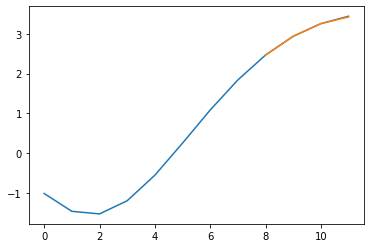

In [24]:
predicted_forces = predict_forces()
print(predicted_forces)
force_df = pd.read_csv("Data/Moldyn_dataframe_for.csv")
plt.plot(range(12), force_df['C1(x)'][:12])
plt.plot(range(input, input+pred_step), predicted_forces[0,0,:])